<a href="https://colab.research.google.com/github/BrajanNieto/Mlearning/blob/main/Hackaton_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Título: Diseño, Implementación y Evaluación de una Red Neuronal MLP para la Clasificación de Rostros

----

# Descripción:
En este hackathon, cada equipo desarrollarán un modelo de red neuronal de tipo Perceptrón Multicapa (MLP) utilizando PyTorch para clasificar una base de datos de imágenes de rostros. La base de datos consta de 2,410 imágenes, cada imagen está representada como un vector de  dimensión de 32256. Las imágenes corresponden a 38 personas diferentes, donde cada persona tiene múltiples fotografías. El objetivo principal es explorar diferentes configuraciones del modelo ajustando el número de neuronas en una capa oculta y utilizando distintas funciones de activación. A través de estas pruebas, los estudiantes analizarán el impacto de los hiperparámetros en el rendimiento del modelo, implementarán modificaciones en el código base provisto y presentarán una evaluación cuantitativa de los resultados.

----

# Objetivos:
## General:

Diseñar, implementar y evaluar una red neuronal MLP en PyTorch para la clasificación de imágenes de rostros.
## Específicos:
- Convertir y preparar los datos de imágenes en un formato adecuado para el entrenamiento del modelo.
- Implementar una red neuronal MLP con una sola capa oculta y explorar el impacto del número de neuronas en el rendimiento del modelo.
- Experimentar con diferentes funciones de activación, como ReLU, Sigmoid y Tanh, para observar sus efectos en la clasificación.
- Implementar y completar el código base provisto, asegurando que sea funcional y eficiente.
- Entrenar y evaluar múltiples configuraciones de la red neuronal utilizando métricas como accuracy, recall, precision y F1 score.
- Comparar los resultados de las distintas configuraciones y determinar cuál ofrece el mejor desempeño.
- Presentar los resultados en tablas y gráficas, explicando las conclusiones obtenidas.

## Base de Datos:

Link: [Aquí](https://drive.google.com/file/d/1X8-AJiG0_qW08rx5l8u1Vs3cmx5W8ETj/view?usp=sharing)


**Para aprender, debemos entrenar nuestra propia red neuronal. No dependas de herramientas como ChatGPT o sus variantes. Entrena tu cerebro, equivócate, identifica los errores y aprende de ellos, tal como lo haría una red neuronal MLP gigante.**

----

Mucha suerte y divierntanse aprendiendo. 😊😊😊

Nombres y Apellidos:
- Lopez Medina Sebastián (100%)
- Nieto Espinoza Brajan (100%)
- Tapia Cahsquibol Mateo (100%)

# Resultados y conclusiones

En la experimentación se hizo una búsqueda en malla sobre tamaños ocultos (32, 64, 128, 256, 512), funciones de activación (leakyrelu, relu, tanh, sigmoid) y dropouts (0.0, 0.1, 0.2, 0.3). Se seleccionó, para cada activación, la mejor configuración en el conjunto de train (con f1-score de hasta ~0.99) y esas cuatro se evaluaron en test. Los resultados en test fueron:

    leakyrelu (hidden_size=128, dropout=0.3): accuracy 97.84%, f1-score 97.78%

    relu (hidden_size=128, dropout=0.2): accuracy 97.18%, f1-score 97.25%

    sigmoid (hidden_size=512, dropout=0.0): accuracy 95.19%, f1-score 94.65%

    tanh (hidden_size=512, dropout=0.0): accuracy 92.04%, f1-score 91.85%

Conclusión: para el problema de reconocimiento de rostros, la configuración más efectiva fue un MLP con activación leakyrelu, tamaño oculto intermedio (128) y dropout elevado (0.3), ya que alcanzó el mejor balance entre precisión y generalización en test. Como siguientes pasos recomendados se sugiere afinar la tasa de aprendizaje, aplicar early stopping para prevenir sobreajuste leve y evaluar ensamblados (por ejemplo combinando leakyrelu y relu) para aumentar la robustez del sistema.


---

# 1. Librerías Necesarias

In [1]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import seaborn as sns
from google.colab import drive

# 2. Cargando datos de Archivo

La función load_data carga todas las imágenes de un archivo .m.
No se preocupe por eso, se hará de forma transparente para usted.

In [2]:

#drive.mount('/content/drive')
path = 'allFaces'
def Load_data(file):
  faces_m_format = scipy.io.loadmat(path)
  faces = faces_m_format['faces']
  m = int(faces_m_format['m'])
  n = int(faces_m_format['n'])
  nfaces = np.ndarray.flatten(faces_m_format['nfaces'])
  y = np.zeros((faces.shape[1],))
  j = 0
  classes = list(range(len(nfaces)))
  for i in nfaces:
    y[j:j+i] = classes.pop(0)
    j = j + i
  print("Total dataset size:")
  print(f"n_samples: {faces.shape[1]}")
  print(f"n_features: {m*n}")
  print(f"n_classes: {len(nfaces)}")
  return faces, y,m,n

X,Y,m,n = Load_data('allFaces.mat')

Total dataset size:
n_samples: 2410
n_features: 32256
n_classes: 38


/tmp/ipython-input-3155216329.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m = int(faces_m_format['m'])
/tmp/ipython-input-3155216329.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(faces_m_format['n'])
/tmp/ipython-input-3155216329.py:18: RuntimeWarning: overflow encountered in scalar add
  y[j:j+i] = classes.pop(0)
/tmp/ipython-input-3155216329.py:19: RuntimeWarning: overflow encountered in scalar add
  j = j + i


## Funciones Utilitarias.
La función Plot_Face se ha implementado para que pueda ver una imagen de su base de datos.

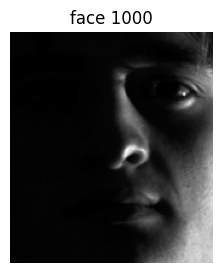

(32256, 2410)

In [3]:
def Plot_Face(image_vec, i,title):
  fig1 = plt.figure(figsize=(10, 3))
  image = image_vec.reshape((m,n))
  img = plt.imshow(image.T)
  img.set_cmap('gray')
  plt.title(title  + str(i))
  plt.axis('off')
  plt.show()


number_image = 1000
image_vec = X.T[number_image]
Plot_Face(image_vec,number_image,'face ')
X.shape

# 3. Reducción de la dimensionalidad

Completa el código para que sea funcional y permita reducir los datos, asegurando que se conserve el 95% de la varianza explicada.

In [4]:
import numpy as np
from sklearn.decomposition import PCA
pca=PCA(n_components=0.95)
X_pca=  pca.fit_transform(X.T)
print(f"Original dims: {X.shape[1]}, Reduced dims: {X_pca.shape[1]} (explained variance ratio sum: {pca.explained_variance_ratio_.sum():.4f})")

Original dims: 2410, Reduced dims: 62 (explained variance ratio sum: 0.9502)


# 4. Separación de datos en train y test.
Complete el código usando la libreria train_test_split

1.  Divide los datos en conjuntos de entrenamiento y prueba utilizando train_test_split con un 25% para prueba.
2.  Recuerda que los datos a dividir son X_pca y Y.
3. Convierte los datos a tensores para que PyTorch pueda procesarlos correctamente.
4. Crear los dataloader para entrerar y testear el modelo. Se da un ejemplo.


In [17]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

In [18]:
# Escriba su código aquí para separar la data
X_train, X_test, y_train, y_test = train_test_split( X_pca, Y, test_size=0.25, random_state=42)

In [19]:
# Convierte tus datos a tensores.
# A continuación, te doy un ejemplo para X_test y Y_test.

#x_test_t = torch.tensor(X_test, dtype=torch.float32)
#y_test_t = torch.tensor(y_test, dtype=torch.long)


x_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
x_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

In [20]:
# Crear TensorDataset y DataLoader. Te pongo un ejemplo para el test
#dataset_test = TensorDataset(x_test_t, y_test_t)
#batch_size = 16
#data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

batch_size = 16
dataset_train = TensorDataset(x_train_t, y_train_t)
dataset_test = TensorDataset(x_test_t, y_test_t)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# 5. Modelo

Crea tu modelo MLP utilizando una  capa. Puedes experimentar con el número de neuronas en esa capa y las funciones de activación.

In [21]:
class Modelo_MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation='relu', dropout=0.0):
        super(Modelo_MLP, self).__init__()
        self.activation_name = activation.lower()
        if self.activation_name == 'relu':
            self.activation = nn.ReLU()
        elif self.activation_name == 'tanh':
            self.activation = nn.Tanh()
        elif self.activation_name == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif self.activation_name == 'leakyrelu':
            self.activation = nn.LeakyReLU(0.01)
        else:
            raise ValueError(f"Activación no soportada: {activation}")

        layers = [
            nn.Linear(input_size, hidden_size), #el hiden layer
            self.activation # activacion
        ]
        if dropout and dropout > 0.0:
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_size, output_size))

        self.net = nn.Sequential(*layers)

        # Inicialización de pesos
        for m in self.net:
            if isinstance(m, nn.Linear):
                if self.activation_name in ['relu', 'leakyrelu']:
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                else:  # tanh or sigmoid
                    nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)


# 6. Configuración de Parámetros
Configura los parámetros de tu modelo

In [22]:
# Parámetros del modelo
input_size = X_pca.shape[1]
hidden_sizes = [128, 64, 32]  # variantes a probar
output_size = len(np.unique(Y))
epochs = 50

# Instanciación (aquí se usa la primera configuración de capa oculta)
model = Modelo_MLP(input_size, hidden_sizes[0], output_size, activation='relu', dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 7. Entrenamiento.
Completar el código que falta para que la función se ejecute correctamente.

In [23]:
def train(model, criterion, optimizer, data_loader, epochs):
    device = next(model.parameters()).device
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x_batch.size(0)
        avg_loss = total_loss / len(data_loader.dataset)
        print(f"Época {epoch + 1}/{epochs}, Pérdida promedio: {avg_loss:.4f}")


# 8. Testing
Completa el código necesario para evaluar tu modelo.
Se solicita que ajustes algunos hiperparámetros para crear al menos 3 modelos diferentes y mostrar sus resultados en una tabla.

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import torch

def evaluate(model, data_loader):
    model.eval()
    device = next(model.parameters()).device
    y_pred = []
    y_real = []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_real.extend(y_batch.cpu().numpy())

    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_real, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_real, y_pred, average='weighted', zero_division=0)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }



In [27]:
# Configuraciones a probar: al menos 3 modelos distintos
configurations = [
    {'hidden_size': 64, 'activation': 'relu', 'dropout': 0.1},
    {'hidden_size': 64, 'activation': 'relu', 'dropout': 0.1},
    {'hidden_size': 128, 'activation': 'relu', 'dropout': 0.2},
    {'hidden_size': 256, 'activation': 'relu', 'dropout': 0.2},
    {'hidden_size': 128, 'activation': 'tanh', 'dropout': 0.0},
    {'hidden_size': 64, 'activation': 'tanh', 'dropout': 0.1},
    {'hidden_size': 128, 'activation': 'tanh', 'dropout': 0.2},
    {'hidden_size': 256, 'activation': 'tanh', 'dropout': 0.2},
    {'hidden_size': 64, 'activation': 'leakyrelu', 'dropout': 0.2},
    {'hidden_size': 128, 'activation': 'leakyrelu', 'dropout': 0.2},
    {'hidden_size': 256, 'activation': 'leakyrelu', 'dropout': 0.2},
    {'hidden_size': 64, 'activation': 'sigmoid', 'dropout': 0.2},
    {'hidden_size': 128, 'activation': 'sigmoid', 'dropout': 0.2},
    {'hidden_size': 256, 'activation': 'sigmoid', 'dropout': 0.2},
    {'hidden_size': 512, 'activation': 'sigmoid', 'dropout': 0.1},
]

results = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for cfg in configurations:
    model = Modelo_MLP(input_size, cfg['hidden_size'], output_size,
                       activation=cfg['activation'], dropout=cfg['dropout']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entrenar
    train(model, criterion, optimizer, data_loader_train, epochs)

    # Evaluar en train y test
    train_metrics = evaluate(model, data_loader_train)
    test_metrics = evaluate(model, data_loader_test)

    results.append({
        'hidden_size': cfg['hidden_size'],
        'activation': cfg['activation'],
        'dropout': cfg['dropout'],
        'set': 'train',
        **train_metrics
    })
    results.append({
        'hidden_size': cfg['hidden_size'],
        'activation': cfg['activation'],
        'dropout': cfg['dropout'],
        'set': 'test',
        **test_metrics
    })

# Mostrar resultados en tabla
df_results = pd.DataFrame(results)
print(df_results.sort_values(['hidden_size', 'activation', 'set']))


Época 1/50, Pérdida promedio: 1140.2285
Época 2/50, Pérdida promedio: 168.5144
Época 3/50, Pérdida promedio: 119.5572
Época 4/50, Pérdida promedio: 84.1721
Época 5/50, Pérdida promedio: 64.6359
Época 6/50, Pérdida promedio: 51.3615
Época 7/50, Pérdida promedio: 37.8865
Época 8/50, Pérdida promedio: 27.2385
Época 9/50, Pérdida promedio: 29.0378
Época 10/50, Pérdida promedio: 21.1659
Época 11/50, Pérdida promedio: 19.2624
Época 12/50, Pérdida promedio: 14.7473
Época 13/50, Pérdida promedio: 16.9209
Época 14/50, Pérdida promedio: 11.9675
Época 15/50, Pérdida promedio: 10.2746
Época 16/50, Pérdida promedio: 10.5651
Época 17/50, Pérdida promedio: 7.0483
Época 18/50, Pérdida promedio: 8.6611
Época 19/50, Pérdida promedio: 8.3576
Época 20/50, Pérdida promedio: 6.6828
Época 21/50, Pérdida promedio: 6.5247
Época 22/50, Pérdida promedio: 6.6044
Época 23/50, Pérdida promedio: 4.7426
Época 24/50, Pérdida promedio: 4.4965
Época 25/50, Pérdida promedio: 5.7626
Época 26/50, Pérdida promedio: 4.1274
É

# 9. Ejecutando y evaluando el modelo
- Si el código anterior es correcto, el siguiente fragmento debería ejecutarse sin problemas.
- El entrenamiento del modelo puede tardar entre 5 y 10 minutos, por lo que se recomienda tener paciencia.
- Sugerencia: cada miembro del equipo puede probar configuraciones diferentes del modelo y, posteriormente, reunir los resultados en una tabla única para evaluar cuál ofrece el mejor desempeño.


In [29]:
import itertools
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

#  hiperparametros
hidden_grid = [32, 64, 128, 256, 512]
activations = ['relu', 'tanh', 'leakyrelu', 'sigmoid']
dropouts = [0.0, 0.1, 0.2, 0.3]

configs = [{'hidden_size': h, 'activation': a, 'dropout': d}
           for h, a, d in itertools.product(hidden_grid, activations, dropouts)]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_records = []
trained_models = {}  #mejor por activación

for cfg in configs:
    model = Modelo_MLP(input_size, cfg['hidden_size'], output_size,
                       activation=cfg['activation'], dropout=cfg['dropout']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train(model, criterion, optimizer, data_loader_train, epochs)
    tr_metrics = evaluate(model, data_loader_train)

    train_records.append({
        'hidden_size': cfg['hidden_size'],
        'activation': cfg['activation'],
        'dropout': cfg['dropout'],
        **tr_metrics
    })
    trained_models[(cfg['hidden_size'], cfg['activation'], cfg['dropout'])] = model

# Tabla 1: resultados de TRAIN
df_train = pd.DataFrame(train_records)
df_train = df_train.sort_values(['activation', 'hidden_size', 'dropout']).reset_index(drop=True)
print("\n=== Resultados en TRAIN (todas las combinaciones) ===")
print(df_train)

# Seleccionar el MEJOR por cada activación usando accuracy o mejor f1_score
df_train_sorted = df_train.sort_values(['activation', 'accuracy', 'f1_score'],
                                       ascending=[True, False, False])
best_per_activation = df_train_sorted.drop_duplicates(subset=['activation'], keep='first')

# Evaluar en TEST
test_records = []
for _, row in best_per_activation.iterrows():
    key = (int(row['hidden_size']), row['activation'], float(row['dropout']))
    best_model = trained_models[key]
    te_metrics = evaluate(best_model, data_loader_test)
    test_records.append({
        'activation': row['activation'],
        'hidden_size': int(row['hidden_size']),
        'dropout': float(row['dropout']),
        **te_metrics
    })

# Tabla 2: Resultados en TEST d
df_test_best = pd.DataFrame(test_records).sort_values(['activation']).reset_index(drop=True)
print("\n=== Resultados en TEST (mejor configuración por activación) ===")
print(df_test_best)


Época 1/50, Pérdida promedio: 945.6286
Época 2/50, Pérdida promedio: 154.4090
Época 3/50, Pérdida promedio: 79.4492
Época 4/50, Pérdida promedio: 46.8043
Época 5/50, Pérdida promedio: 27.4999
Época 6/50, Pérdida promedio: 18.4121
Época 7/50, Pérdida promedio: 14.0295
Época 8/50, Pérdida promedio: 10.0714
Época 9/50, Pérdida promedio: 8.2909
Época 10/50, Pérdida promedio: 6.4186
Época 11/50, Pérdida promedio: 5.4718
Época 12/50, Pérdida promedio: 4.8282
Época 13/50, Pérdida promedio: 3.7925
Época 14/50, Pérdida promedio: 3.0775
Época 15/50, Pérdida promedio: 3.0369
Época 16/50, Pérdida promedio: 2.3374
Época 17/50, Pérdida promedio: 2.2721
Época 18/50, Pérdida promedio: 1.9751
Época 19/50, Pérdida promedio: 1.3513
Época 20/50, Pérdida promedio: 1.2553
Época 21/50, Pérdida promedio: 1.2809
Época 22/50, Pérdida promedio: 1.0926
Época 23/50, Pérdida promedio: 1.3466
Época 24/50, Pérdida promedio: 1.4912
Época 25/50, Pérdida promedio: 1.8213
Época 26/50, Pérdida promedio: 1.5255
Época 27/50

Configura tu red, con diferentes número de neuronas y cambia las funciones de activación y genera
una tabla, con los siguientes datos

Esta es sólo una tabla de ejemplo:

----
| Neuronas Hidden | Tipo de Función de Activación | Número de Épocas | Accuracy | Recall | Precision | F1_Score |
|------------------|-------------------------------|------------------|----------|--------|-----------|----------|
| 64, 32          | ReLU                          | 10               | 0.85     | 0.84   | 0.86      | 0.85     |
| 128, 64         | Tanh                          | 20               | 0.89     | 0.88   | 0.90      | 0.89     |
| 256, 128        | Sigmoid                       | 15               | 0.83     | 0.82   | 0.84      | 0.83     |
| 512, 256        | ReLU                          | 30               | 0.91     | 0.90   | 0.92      | 0.91     |

-----